In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [6]:
path_dir = './LFW-FER/eval/negative/'
file_list = os.listdir(path_dir)
# file_list[0]

In [7]:
#figure setting

def fig_set(fig, rows, cols, num, img, label):
    ax = fig.add_subplot(rows, cols, num)
    ax.imshow(img)
    ax.set_xlabel(label, color = 'white', fontsize=15)
    ax.set_xticks([]), ax.set_yticks([])
    ax.figure.set_size_inches((15,15))

- plt.imshow()함수는 RGB 순으로 해석, OpenCV는 컬러 이미지를 BGR순으로 인식 하므로 컬러를 뒤집어서 나타내 주어야함

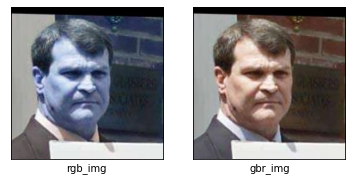

In [8]:
img = np.zeros((120, 120), dtype=np.uint8)
img_rgb = cv2.imread(path_dir + file_list[0])
img_gbr = img_rgb[:,:,::-1]

fig = plt.figure()
fig_set(fig, 1, 2, 1, img_rgb, 'rgb_img')
fig_set(fig, 1, 2, 2, img_gbr, 'gbr_img')

- img 자체에 연산을 하게 되면, 이미지 내에 있는 모든 배열의 벨류값에 100을 더해주게 된다.  
  -->  ```포화연산처리가 안되어 이미지 색상이 이상하게 나온다```
  * 포화연산: 픽셀 값이 최대치와 최소치를 넘으면 최대치와 최소치로 처리하는 연산

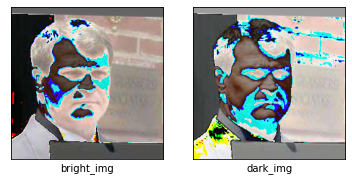

In [9]:
img1 = img_gbr + 100
img2 = img_gbr - 100

fig = plt.figure()

fig_set(fig, 1, 2, 1, img1, 'bright_img')
fig_set(fig, 1, 2, 2, img2, 'dark_img')

- int32: ```-2147483648 ~ 2147483648   (부호 있음)```
- Uint8: ```0 ~ 255                    (부호 없음)```

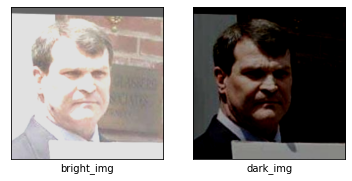

In [10]:
img1 = np.clip(img_gbr.astype('int32')+100,0,225).astype('uint8')
img2 = np.clip(img_gbr.astype('int32')-100,0,225).astype('uint8')

fig = plt.figure()

fig_set(fig, 1, 2, 1, img1, 'bright_img')
fig_set(fig, 1, 2, 2, img2, 'dark_img')

- Trackbar를 이용한 이미지 밝기 조절

In [11]:
def trackbar_bright(img, num):
    return np.clip(img.astype('int32')+num,0,225).astype('uint8')

def trackbar_dark(img, num):
    return np.clip(img.astype('int32')-num,0,225).astype('uint8')

In [12]:

cv2.imshow('img', img_rgb)
cv2.createTrackbar('bright', 'img', 0, 100, lambda pos: cv2.imshow('img', trackbar_bright(img_rgb, pos)))
cv2.createTrackbar('dark', 'img', 0, 100, lambda pos: cv2.imshow('img', trackbar_dark(img_rgb, pos)))
cv2.waitKey(0)
cv2.destroyAllWindows()

## 색상 변환
->  이미지의 색상 표현을 변환하면서 특정 부분의 색을 검출

### **YCrCb(YCC)**  
- ```YUV(Y:Luminance, U:Blue color, V:Red color)```에서 아날로그 방식일 때는 ***YPbPr***로 표현하고, 디지털 방식일 때는 ***YCbCr***로 표현한다.  
- Y는 휘도(밝기), Cb, Cr은 색차 성분을 뜻한다. 따라서 Y가 크면 밝고, Y가 작으면 어둡다.
- YCbCr Color Space내에서 사람의 피부는 (0,133,77) ~ (255,173,127) 영역 내에 존재.  

  
### **HSV(Hue, SATURATION, Value)**
- ```H(Hue: 색상)```는 가시광선 스펙트럼을 고리모양으로 배치한 색상환에서 가장 파장이 긴 빨강을 0°로 하였을 때 상대적인 배치 각도를 의미하며 0°~360°의 범위를 가진다.(8비트 범위내에서 표현할 때는 0 ~ 255)
- ```S(Saturation: 채도)```는 특정한 색상의 진함의 정도를 나타낸다. 가장 진한 상태를 100*이고 0%는 같은 명도의 무채색이다.
- ```V(Value: 명도)```는 밝은 정도를 나타낸다. 순수한 흰색, 빨간색은 100%이고 검은색은 0%이다.

In [13]:
def RGB_YCrCb(img_dir):
    img = cv2.imread(img_dir)
    YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    mask = cv2.inRange(YCrCb, np.array([0, 133, 77]), np.array([255, 173, 127]))

    skin = cv2.bitwise_and(img, img, mask = mask)
    return YCrCb, mask, skin

def RGB_hsv(img_dir):
    lower = (0, 48, 80)
    upper = (20, 255, 255)
    img = cv2.imread(img_dir)
    HSVimg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(HSVimg, lower, upper)

    skin = cv2.bitwise_and(img, img, mask = mask)
    return HSVimg, mask, skin

In [14]:
ycrcb, ycrcb_mask, ycrcb_skin = RGB_YCrCb(path_dir+file_list[0])
hsv, hsv_mask, hsv_skin = RGB_hsv(path_dir+file_list[0])

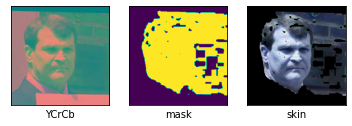

In [15]:
fig = plt.figure()

fig_set(fig, 1, 3, 1, ycrcb, 'YCrCb')
fig_set(fig, 1, 3, 2, ycrcb_mask, 'mask')
fig_set(fig, 1, 3, 3, ycrcb_skin, 'skin')

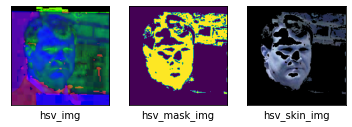

In [16]:
fig = plt.figure()

fig_set(fig, 1, 3, 1, hsv, 'hsv_img')
fig_set(fig, 1, 3, 2, hsv_mask, 'hsv_mask_img')
fig_set(fig, 1, 3, 3, hsv_skin, 'hsv_skin_img')

### **Otsu 알고리즘**
- 어떤 영상을 thresholding하고 싶을 때, 적정한 threshold 값을 찾아주는 알고리즘
- grayscale 이미지의 적합한 threshold를 정해서 픽셀들을 두 부류로 나누고 반복해서 구한 후 명암 분포를 가장 균일하게 하는 경계값을 가지는 흑과 백만 가진 영상으로 변환하는 알고리즘이다. (백색은 0, 검은색은 255를 의미한다.)

In [31]:
img = cv2.imread(path_dir+file_list[0], cv2.IMREAD_GRAYSCALE)
_, t_cus = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

t, t_otsu = cv2.threshold(img, -1, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print('threshold: ', t)

threshold:  125.0


In [32]:
def fig_set(fig, rows, cols, num, img, label):
    ax = fig.add_subplot(rows, cols, num)
    ax.imshow(img, cmap = 'gray')
    ax.set_xlabel(label)
    ax.set_xticks([]), ax.set_yticks([])

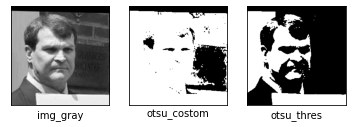

In [33]:
fig = plt.figure()

fig_set(fig, 1, 3, 1, img, 'img_gray')
fig_set(fig, 1, 3, 2, t_cus, 'otsu_costom')
fig_set(fig, 1, 3, 3, t_otsu, 'otsu_thres')